In [1]:
import os
import sys
sys.path.append('../')
os.chdir('../')

import pyro
import pyro.distributions as dist

from scipy import stats as sps
from utilidades import *

(array(4.7), array(8.41), array(2.08597324), array(8.61770907))


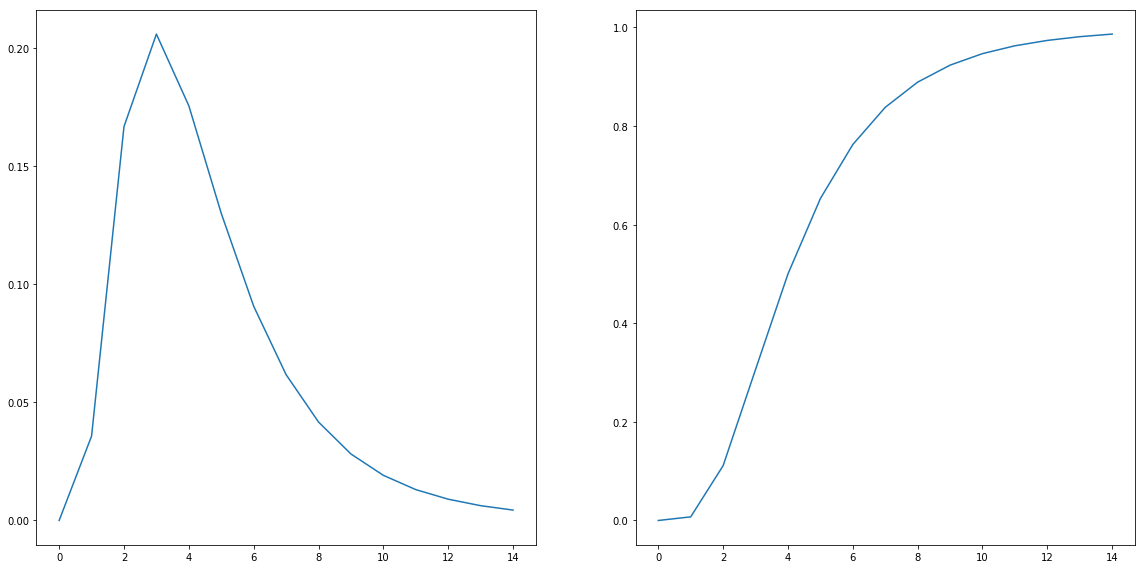

In [2]:
def plot_dist(dist, samples, **kwargs):
    print(dist.stats(moments='mvsk'))
    
    fig, axs = pyplot.subplots(ncols=2, nrows=1)
    axs[0].plot(samples, dist.pdf(samples), **kwargs)
    axs[1].plot(samples, dist.cdf(samples), **kwargs)
    
def lognorm(mean_si, std_si):
    mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
    sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
    
    return sps.lognorm(scale=np.exp(mu_si), s=sigma_si)

def gen_interval():
    return lognorm(4.7, 2.9)

plot_dist(gen_interval(), range(15))

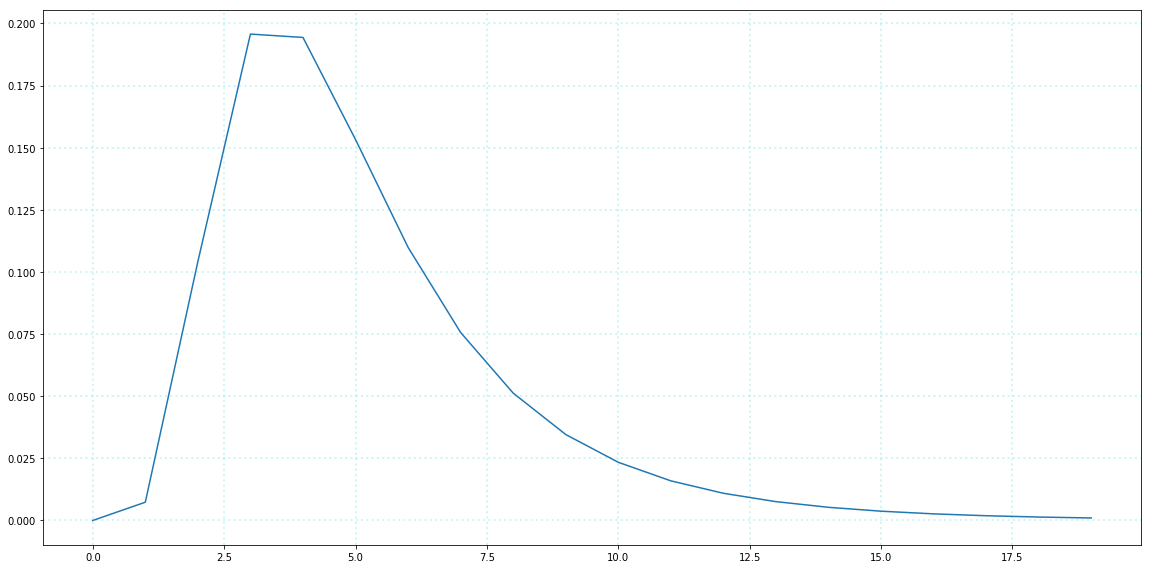

In [3]:
def _get_interval(dist):
    g_range = np.arange(0, 20)
    gt = pd.Series(dist.cdf(g_range), index=g_range)
    gt = gt.diff().fillna(0)
    gt /= gt.sum()
    return gt.values

gt = _get_interval(gen_interval())
plot(range(len(gt)), gt)

In [4]:
def _get_convolution_ready_gt(len_observed):
    gt = _get_interval(gen_interval())
    convolution_ready_gt = np.zeros((len_observed, len_observed))
    for t in range(1, len_observed + 1):
        begin = np.maximum(0, t - len(gt) + 1)
        slice_update = gt[1 : t - begin + 1][::-1]
        convolution_ready_gt[
            t - 1, begin : begin + len(slice_update)
        ] = slice_update
        
    return convolution_ready_gt

data = load_data()
convolution_ready_gt = _get_convolution_ready_gt(len(data[0]))
convolution_ready_gt

array([[0.00735205, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1041599 , 0.00735205, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19569517, 0.1041599 , 0.00735205, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00735205, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.1041599 , 0.00735205,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.19569517, 0.1041599 ,
        0.00735205]])

In [5]:
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
import pyro.contrib

pyro.enable_validation(True)

In [15]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
convolution_ready_gt = torch.tensor(convolution_ready_gt)

class GaussianRandomWalk(dist.TorchDistribution):
    has_rsample = True
    arg_constraints = {'scale': constraints.positive}
    support = constraints.real

    def __init__(self, scale, num_steps=1):
        self.scale = scale
        batch_shape, event_shape = scale.shape, torch.Size([num_steps])
        super(GaussianRandomWalk, self).__init__(batch_shape, event_shape)

    def rsample(self, sample_shape=torch.Size()):
        shape = sample_shape + self.batch_shape + self.event_shape
        walks = self.scale.new_empty(shape).normal_()
        return walks.cumsum(-1) * self.scale.unsqueeze(-1)

    def log_prob(self, x):
        init_prob = dist.Normal(self.scale.new_tensor(0.), self.scale).log_prob(x[..., 0])
        step_probs = dist.Normal(x[..., :-1], self.scale).log_prob(x[..., 1:])
        return init_prob + step_probs.sum(-1)
    

# https://github.com/rtcovidlive/covid-model
def model(total):
    T = len(total)
    step_size = torch.tensor(.035)

    gaussian_walk = dist.Normal(
        loc=torch.zeros(T), 
        scale=torch.ones(T) * step_size
    )
#     gaussian_walk = dist.MultivariateNormal(
#         loc=torch.zeros(T), 
#         scale_tril=torch.ones((T, T)).tril() * step_size
#     )
#     gaussian_walk = GaussianRandomWalk(step_size, num_steps=T)
    log_r_t = pyro.sample('log_r_t', gaussian_walk)
    log_r_t = torch.cumsum(log_r_t, dim=0)
    r_t = torch.exp(log_r_t)
    
    positivity_profile = torch.zeros((1, T))
    positivity_profile[0][0] = pyro.sample('positivity_t0', dist.Exponential(.1))
    
    # y_t -- positivity
    # P(GT = i) = g_i -- PMF generation interval distribution
    # Sum_i=1->M (R_e(t - i) * g_i * y_t_-_i)
    for i in range(1, T):
        tens = torch.tensor(positivity_profile[-1])
        tens[i] = torch.sum(
            r_t * convolution_ready_gt[i] * positivity_profile[i - 1]
        )
        tens = tens.view(1, T)
        positivity_profile = torch.cat((positivity_profile, tens), 0)
        
    positivity_profile = pyro.deterministic('positivity_profile', positivity_profile[-1])
    sim_positive = positivity_profile * total
#     probabilities = pyro.sample(
#         'probabilities', 
#         dist.Gamma(36., 6.)
#     )
    
    positive = dist.NegativeBinomial(
        sim_positive,
        probs=.5
    )
    
    with pyro.plate('observe_data'):
        return pyro.sample('positive', positive)
    

In [16]:
active_cases = data[1].copy()
active_cases[active_cases < 1] = 1.

total_tests = data[-1] + data[3]
total_tests[total_tests < 1] = 1.

observed_tensor = {
    'total': torch.tensor(total_tests),
    'positive': torch.tensor(active_cases)
}

conditioned_model = pyro.condition(model, data={'positive': observed_tensor['positive']})

import pyro.infer
import pyro.optim

pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoDiagonalNormal(conditioned_model)

svi = pyro.infer.SVI(
    model=conditioned_model,
    guide=guide,
    optim=pyro.optim.SGD({'lr': 0.001, 'momentum':0.1}),
    loss=pyro.infer.Trace_ELBO()
)

losses = []
for _ in range(100):
    loss = svi.step(observed_tensor['total'])
    print(loss)
    losses.append(loss)

In [17]:
from pyro.infer.mcmc import MCMC, NUTS
pyro.clear_param_store()

nuts_kernel = NUTS(conditioned_model, adapt_step_size=True, step_size=.001)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=10)
mcmc.run(observed_tensor['total'])

Sample: 100%|██████████| 510/510 [01:09,  7.29it/s, step size=1.69e-03, acc. prob=0.003]


In [19]:
posterior_samples = mcmc.get_samples()
posterior_predictive = pyro.infer.Predictive(model, posterior_samples).get_samples(
    observed_tensor['total']
)
prior = pyro.infer.Predictive(model, num_samples=500).get_samples(
    observed_tensor['total']
)

In [20]:
import arviz

pyro_data = arviz.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
)
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

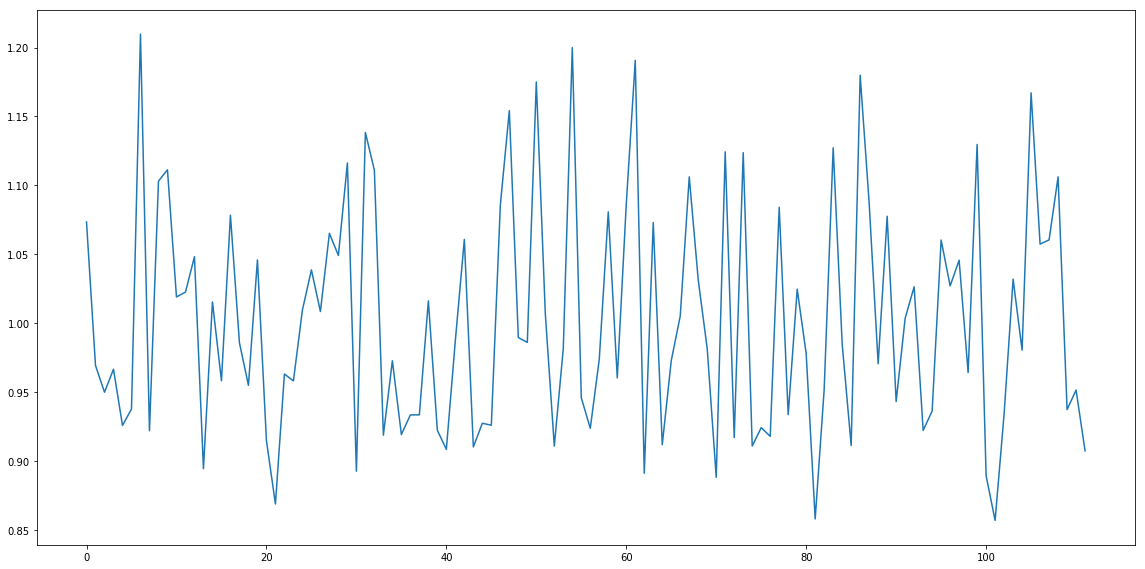

In [21]:
hpdi = arviz.hdi(pyro_data, hdi_prob=.8)

fig, ax = pyplot.subplots()
ax.plot(range(112), np.exp(pyro_data.posterior.log_r_t.median(axis=1)[0]))

In [12]:
mcmc.summary(.5)


                     mean       std    median     25.0%     75.0%     n_eff     r_hat
     log_r_t[0]     -0.32      0.02     -0.32     -0.34     -0.32      2.44      2.80
     log_r_t[1]      0.94      0.02      0.93      0.93      0.95      2.71      2.32
     log_r_t[2]     -0.35      0.02     -0.35     -0.35     -0.33      2.57      2.48
     log_r_t[3]      0.35      0.02      0.35      0.33      0.36      2.59      2.43
     log_r_t[4]     -1.09      0.01     -1.08     -1.09     -1.08      2.86      2.15
     log_r_t[5]     -1.39      0.02     -1.38     -1.38     -1.36      2.45      2.71
     log_r_t[6]      0.13      0.01      0.13      0.12      0.13      2.70      2.34
     log_r_t[7]      0.41      0.00      0.41      0.41      0.41      4.51      1.08
     log_r_t[8]      0.80      0.01      0.80      0.79      0.80      2.44      2.90
     log_r_t[9]      0.26      0.01      0.26      0.26      0.27      3.10      1.87
    log_r_t[10]      0.23      0.00      0.23      0.

* Fallo miserablemente